# Business Understanding

Business Problem: What are the top 5 best zip codes for millennials to invest in?

**Who are our clients?**

1. First-time homebuyers who are millennials (born 1981-1996)
    - Assumptions:
    - Median incomes (not in the upper 5%, but also not below poverty levels)
    - Looking to see some return on investment within the two years
    - What kind of spread on forecast will be most appropriate/acceptable for first-time homebuyers?

2. How are we defining "best" zip code?
    - Highest ROI since 2011 - after the housing market recovered from the housing crash of 2008-2009
    - But, utilize full market history when making forecasts to account for all trends

Your recommendation will need to detail your rationale and answer any sort of lingering questions like these in order to demonstrate how you define "best".

It is important to understand that time series modeling is a tool in your toolbox, and the forecasts it provides you are what you'll use to answer important questions.

* Forecasts to show:
    - Average expected ROI
    - Range of appreciation, determining "safe" investments with small ranges vs. "riskier" investments with a wide range

In short, to pass this project, **demonstrating the quality and thoughtfulness of your overall recommendation** is at least as important as successfully building a time series model!


## Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), you need to start with a definition of "best investment". Consider additional metrics like risk vs. profitability, or ROI yield

* Quantitative metric: MAE (which will be literal dollar value) to be able to indicate dollar value of possible error
* "Best investment"
    - Appreciation - raw dollar difference
    - ROI - percentage
    - Smallest CI for low risk
    - Largest CI for high risk
    - Cash on hand affordability
* Time frame - starting with 2011, when the oldest millennials turned 30

# Data Preparation

## Load Libraries

In [137]:
# Basics
import pandas as pd
import numpy as np
#from pyzipcode import ZipCodeDatabase
#from datetime import datetime as dt

# Visualization
import matplotlib.pyplot as plt
#from matplotlib.pylab import rcParams
plt.style.use('ggplot')

# Modeling
import statsmodels.api as sm
#from statsmodels.tsa.stattools import adfuller
import itertools
from sklearn.metrics import mean_absolute_error
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Warnings
import warnings
warnings.filterwarnings("ignore")


## Load Housing Data

In [138]:
df = pd.read_csv('zillow_data.csv')

In [139]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


What do I want to do here?

* Determine raw difference and percent change (ROI?)
* How do I handle the 2008-2009 housing crash?

In [140]:
df = df.drop('RegionID', axis = 1)
df = df.rename({'RegionName': 'zipcode'}, axis = 1)

In [141]:
df.head()

,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Exploratory Data Analysis

### Preprocessing

To help refine our dataset, I want to compute the cumulative percent change of home values for the whole dataset, from 1996 to 2018 as well as the most recent percent change in home values over the most recent five years (2012-2018).

In [142]:
# Find raw difference and ROI
# make copy of df
df1 = df.copy()

# add column with percent change between 2018 and 1996 median value
df1['Cumulative Percent Change'] = (df1['2018-04'] / df1['1996-04']) * 100

df1['5-year Percent Change'] = (df1['2018-04'] / df1['2012-04']) * 100

df1.head()

,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,Cumulative Percent Change,5-year Percent Change,Average median value (22 yrs),2018 median value,Median value delta
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1018700,1024400,1030700,1033800,1030600,308.378217,139.213832,775200.0,1009600.0,234400.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,316600,318100,319600,321100,321800,136.529487,159.464817,205800.0,314100.0,108300.0
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321200,321200,323000,326900,329900,156.796578,130.705230,249500.0,320900.0,71400.0
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1299000,1302700,1306400,1308500,1307000,262.397109,139.324166,1003100.0,1291500.0,288400.0
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,120300,120300,120500,121000,121500,157.179819,107.712766,112400.0,120300.0,7900.0


In [143]:
df2 = df1.copy()

I created individual dataframes for each computed value, so that I could trim each dataframe to only include the Interquartile Range.

I am only including data values within the IQR to meet the business needs of millennials who are first-time homebuyers. Home values above the 75th percentile and below the 25th percentile will not be appropriate homes to include for prospects.

In [144]:
df3 = df2[['zipcode',
           'Metro',
           'Cumulative Percent Change']]

df4 = df2[['zipcode',
           'Metro',
           '5-year Percent Change']]

In [145]:
df3.head(10)

,zipcode,Metro,Cumulative Percent Change
0,60657,Chicago,308.378217
1,75070,Dallas-Fort Worth,136.529487
2,77494,Houston,156.796578
3,60614,Chicago,262.397109
4,79936,El Paso,157.179819
5,77084,Houston,172.947368
6,10467,New York,273.315893
7,60640,Chicago,361.570439
8,77449,Houston,184.696017
9,94109,San Francisco,497.845953


In [146]:
Q1 = df3.quantile(0.25)
Q3 = df3.quantile(0.75)
IQR = Q3 - Q1

df3_trimmed = df3[~((df3 < (Q1 - 1.5 * IQR)) |(df3 > (Q3 + 1.5 * IQR))).any(axis=1)]
cum_pct_top10 = df3_trimmed.head(10).sort_values('Cumulative Percent Change', ascending=False)
cum_pct_top10

,zipcode,Metro,Cumulative Percent Change
7,60640,Chicago,361.570439
0,60657,Chicago,308.378217
6,10467,New York,273.315893
3,60614,Chicago,262.397109
11,32162,The Villages,249.306931
8,77449,Houston,184.696017
5,77084,Houston,172.947368
4,79936,El Paso,157.179819
2,77494,Houston,156.796578
1,75070,Dallas-Fort Worth,136.529487


In [225]:
df3.describe()

,zipcode,Cumulative Percent Change
count,14723.000000,13684.000000
mean,48222.348706,232.560521
std,29359.325439,86.601907
min,1001.000000,46.739130
25%,22101.500000,178.569073
50%,46106.000000,213.948445
75%,75205.500000,261.983287
max,99901.000000,1218.993994


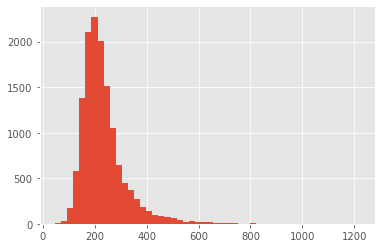

In [229]:
df3['Cumulative Percent Change'].hist(bins=50);

In [226]:
df3_trimmed.describe()

,zipcode,Cumulative Percent Change
count,13987.000000,12948.000000
mean,47398.361193,218.090790
std,28747.304706,57.786498
min,1001.000000,62.453050
25%,22072.500000,176.658449
50%,45385.000000,210.106739
75%,73163.500000,252.012279
max,99901.000000,386.719264


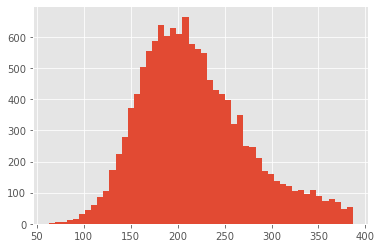

In [230]:
df3_trimmed['Cumulative Percent Change'].hist(bins=50);

### Visualizing Cumulative ROI

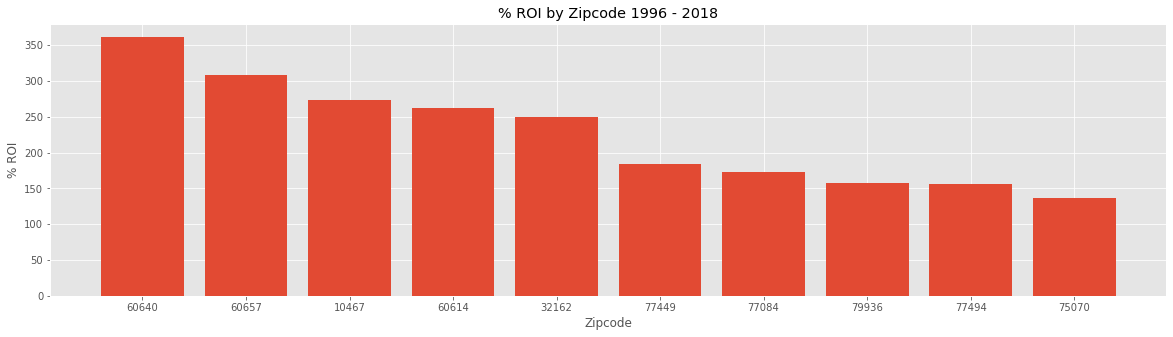

In [147]:
cum_pct_top10['zipcode'] = cum_pct_top10['zipcode'].astype(str)

# Plotting the historical data 
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(cum_pct_top10.zipcode, cum_pct_top10['Cumulative Percent Change'])
plt.title('% ROI by Zipcode 1996 - 2018')
plt.xlabel('Zipcode')
plt.ylabel('% ROI')
plt.show()

In [148]:
Q1 = df4.quantile(0.25)
Q3 = df4.quantile(0.75)
IQR = Q3 - Q1

df4_trimmed = df4[~((df4 < (Q1 - 1.5 * IQR)) |(df4 > (Q3 + 1.5 * IQR))).any(axis=1)]
yrs5_pct_top10 = df4_trimmed.head(10).sort_values('5-year Percent Change', ascending=False)
yrs5_pct_top10

,zipcode,Metro,5-year Percent Change
9,94109,San Francisco,165.538047
1,75070,Dallas-Fort Worth,159.464817
8,77449,Houston,152.951389
5,77084,Houston,146.696429
7,60640,Chicago,141.708907
6,10467,New York,141.565041
3,60614,Chicago,139.324166
0,60657,Chicago,139.213832
2,77494,Houston,130.705230
4,79936,El Paso,107.712766


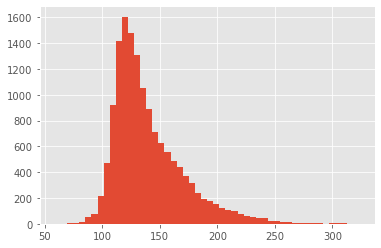

In [231]:
df4['5-year Percent Change'].hist(bins=50);

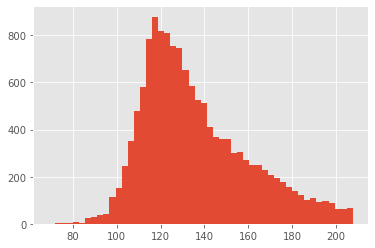

In [232]:
df4_trimmed['5-year Percent Change'].hist(bins=50);

In [233]:
df4_trimmed['5-year Percent Change'].mean()

136.1420128346487

In [234]:
df4['5-year Percent Change'].mean()

139.91164731554213

### Visualizing Most Recent 5-Year ROI

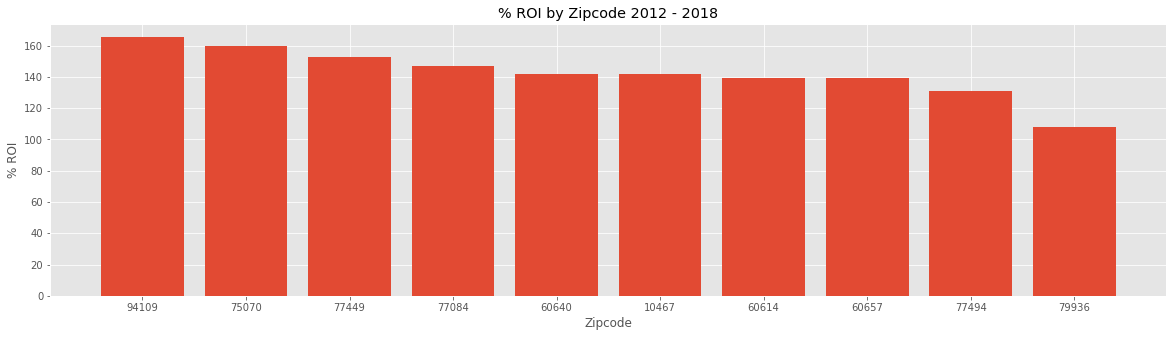

In [149]:
yrs5_pct_top10['zipcode'] = yrs5_pct_top10['zipcode'].astype(str)

# Plotting the historical data 
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(yrs5_pct_top10.zipcode, yrs5_pct_top10['5-year Percent Change'])
plt.title('% ROI by Zipcode 2012 - 2018')
plt.xlabel('Zipcode')
plt.ylabel('% ROI')
plt.show()

In [150]:
cum_pct_top10['zipcode'] = cum_pct_top10['zipcode'].astype(int)
yrs5_pct_top10['zipcode'] = yrs5_pct_top10['zipcode'].astype(int)

from functools import reduce
dfs = [cum_pct_top10, yrs5_pct_top10]

# Combine into one dataframe ONLY those zipcodes that are on each of the Top 10 lists
df_combo = reduce(lambda left,right: pd.merge(left,right,on='zipcode'), dfs)

This shows not only the zipcodes with the highest ROIs over the long run, from 1996 to 2018, but also those zipcodes with the highest ROIs over the past five years.

In [151]:
df_combo

,zipcode,Metro_x,Cumulative Percent Change,Metro_y,5-year Percent Change
0,60640,Chicago,361.570439,Chicago,141.708907
1,60657,Chicago,308.378217,Chicago,139.213832
2,10467,New York,273.315893,New York,141.565041
3,60614,Chicago,262.397109,Chicago,139.324166
4,77449,Houston,184.696017,Houston,152.951389
5,77084,Houston,172.947368,Houston,146.696429
6,79936,El Paso,157.179819,El Paso,107.712766
7,77494,Houston,156.796578,Houston,130.705230
8,75070,Dallas-Fort Worth,136.529487,Dallas-Fort Worth,159.464817


In [152]:
df_combo.drop(columns = ['Metro_y', 'Metro_x'], inplace=True)

In [153]:
df_combo['Average Change'] = (df_combo['Cumulative Percent Change'] + df_combo['5-year Percent Change']) / 2

In [159]:
df_small = df_combo.drop(columns = ['Cumulative Percent Change',
                                    '5-year Percent Change']).sort_values('Average Change',
                                                                          ascending=False).head()

In [160]:
df_small

,zipcode,Average Change
0,60640,251.639673
1,60657,223.796024
2,10467,207.440467
3,60614,200.860637
4,77449,168.823703


In [161]:
zip_list = df_small['zipcode']

In [162]:
df_draft = df[df.zipcode.isin(zip_list)]

df_draft.head(10)

,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
6,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,152400.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,217000.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,96100.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


### Melt Data Function

In [163]:
# This function was provided for us with the dataset at the beginning of this project
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    melted = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'])
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

### Prospective Zipcodes For Analysis

In [164]:
# The code in this cell came courtesy of the other group working on this project 
df_prospects = pd.DataFrame()
for i in df_draft['zipcode']:
    x = melt_data(df_draft[df_draft['zipcode'] == i])
    df_prospects = pd.concat([df_prospects, x], axis=1)
    df_prospects.rename(columns = {'value':i}, inplace = True)
    
df_prospects.head()

,60657,60614,10467,60640,77449
time,,,,,
1996-04-01,334200.0,498100.0,152900.0,216500.0,95400.0
1996-05-01,335400.0,500900.0,152700.0,216700.0,95600.0
1996-06-01,336500.0,503100.0,152600.0,216900.0,95800.0
1996-07-01,337600.0,504600.0,152400.0,217000.0,96100.0
1996-08-01,338500.0,505500.0,152300.0,217100.0,96400.0


In [165]:
df_prospects = df_prospects.asfreq('MS')

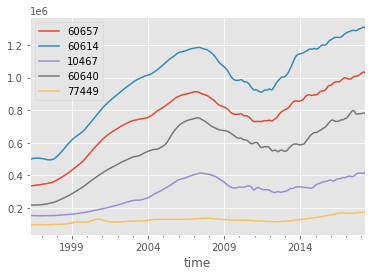

In [166]:
df_prospects.plot();

In [189]:
df_prospects_postcrash = df_prospects['2011-01-31':]

# Modeling

In [190]:
# Create train-validation set
cutoff = round(df_prospects_postcrash.shape[0]*0.8)

**A note on the usage of the SARIMA Model:**

The SARIMA model stands for "Seasonal AutoRegressive Integrated Moving Average" model, so in one swoop, our model can conduct auto-regression, moving average, the integration or differencing of the two, and include the seasonal component of the data.

***

**A note on the SARIMA Parameters:**
Per the formula SARIMA(p,d,q)x(P,D,Q,s), the parameters for these types of models are as follows:

* $p$ and seasonal $P$: indicate number of autoregressive terms (lags of the stationarized series, based on past data points)
* $d$ and seasonal $D$: indicate differencing that must be done to stationarize series (accounting for the overall 'trend' in the data)
* $q$ and seasonal $Q$: indicate number of moving average terms (lags of the forecast errors, based on noise of past data points)
* $s$: indicates seasonal length in the data (in this case, 12 months)

This project utilized a grid search of all the different model iterations with different combinations of pdq and pdqs. For the final model, the pdq and pdqs values were selected based on the smallest AIC value - the AIC is a metric that is an estimator of out-of-sample prediction error; a lower AIC score indicates a more predictive model.

***

**A note on SARIMA Model performance evaluation:**

Use MAE

## Lakeview (Chicago, IL, 60657)

### Lakeview: SARIMA Parameter Search

In [191]:
# Define train and test sets according to the index found above
train1 = df_prospects_postcrash[60657][:cutoff]
valid1 = df_prospects_postcrash[60657][cutoff:]

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []

for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train1,
                                            order = comb,
                                            seasonal_order = combs,
                                            
                                            # with this setting, we are NOT enforcing stationarity
                                            # meaning >???
                                            enforce_stationarity = False,
                                            
                                            # with this setting, we are NOT enforcing invertibility
                                            # meaning >???
                                            enforce_invertibility = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2082.954241088295
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1691.392652248053
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1406.2335878777824
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1112.6567467805478
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1318.334406306487
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1337.3997390951572
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1091.33443324913
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1538.5730425396025
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 2006.7057360154313
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6341989.634026975
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1420.3937640029985
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 1083.490379181547
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1697.946411013325
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1758.3234456782975


In [192]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           810.964
Name: 63, dtype: object

### Lakeview SARIMA Predictions

The Mean Absolute Error of our predictions: $44097.36


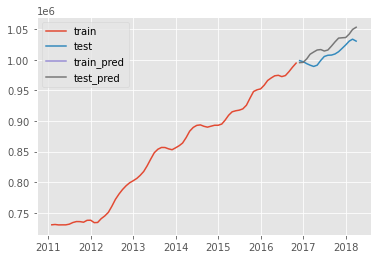

In [241]:
# Plug the optimal parameter values into a new SARIMAX model
sarima1 = sm.tsa.statespace.SARIMAX(train1,
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

y_hat_train1 = sarima1.predict(typ='levels')
y_hat_test1 = sarima1.predict(start=valid1.index[0], end=valid1.index[-1], typ='levels')

# Calculate the mean absolute error from residuals
mae1 = np.mean(np.abs(sarima1.resid))
print('The Mean Absolute Error of our predictions: $%.2f' % mae1)

fig, ax = plt.subplots()
ax.plot(train1, label='train')
ax.plot(valid1, label='test')
ax.plot(y_hat_train1, label='train_pred')
ax.plot(y_hat_test1, label='test_pred')

plt.legend();

### Lakeview SARIMA Forecast

Lakeview (Chicago, IL, 60657):
95% confidence that the true future value is between $759441 and $1624075
Confidence range: $864634


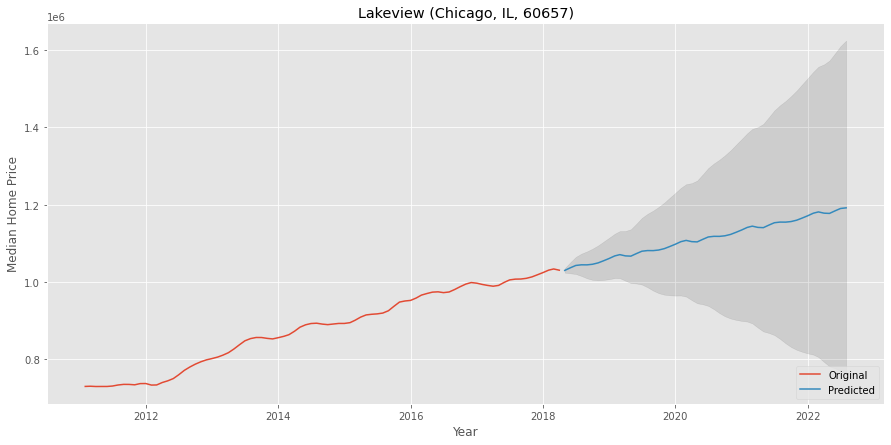

In [212]:
sarima_mod1 = sm.tsa.statespace.SARIMAX(df_prospects_postcrash[60657],
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

forecast1 = sarima_mod1.get_forecast(steps=52).summary_frame()
forecast1_mean = round(forecast1['mean'][51])
low_int1 =  round(forecast1['mean_ci_lower'][51])
high_int1 = round(forecast1['mean_ci_upper'][51])
ci_delta1 = round(high_int1 - low_int1)

print(f'Lakeview (Chicago, IL, 60657):')   
print(f'95% confidence that the true future value is between ${low_int1} and ${high_int1}')
print(f'Confidence range: ${ci_delta1}')

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_prospects_postcrash[60657])
plt.plot(forecast1['mean'])
ax.fill_between(forecast1.index, forecast1['mean_ci_lower'], 
                    forecast1['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Lakeview (Chicago, IL, 60657)')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

### Lakeview Results Summary

## Depaul/Lincoln Park (Chicago, IL, 60614)

### Depaul/Lincoln Park SARIMA Parameters

In [195]:
# Define train and test sets according to the index found above
train2 = df_prospects_postcrash[60614][:cutoff]
valid2 = df_prospects_postcrash[60614][cutoff:]

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []

for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train2,
                                            order = comb,
                                            seasonal_order = combs,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2118.066756904003
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1720.3880845519982
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1448.1598992807756
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1188.3824136682313
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1399.837238924396
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1404.5086705571828
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1137.4301906062833
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1319.8918430424421
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 855950.437719476
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1791.842601995287
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1466.4182159313573
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 1091.193721719454
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1886.2629349250155
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1798.67251388005


In [196]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            817.82
Name: 59, dtype: object

### Depaul/Lincoln Park SARIMA Predictions

The Mean Absolute Error of our predictions: $58447.74


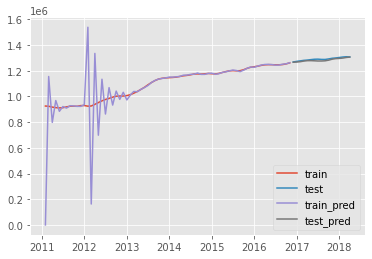

In [197]:
# Plug the optimal parameter values into a new SARIMAX model
sarima2 = sm.tsa.statespace.SARIMAX(train2,
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

y_hat_train2 = sarima2.predict(typ='levels')
y_hat_test2 = sarima2.predict(start=valid2.index[0], end=valid2.index[-1],typ='levels')

# Calculate the mean absolute error from residuals
mae2 = np.mean(np.abs(sarima2.resid))
print('The Mean Absolute Error of our predictions: $%.2f' % mae2)

fig, ax = plt.subplots()
ax.plot(train2, label='train')
ax.plot(valid2, label='test')
ax.plot(y_hat_train2, label='train_pred')
ax.plot(y_hat_test2, label='test_pred')

plt.legend();

### Depaul/Lincoln Park SARIMA Forecast

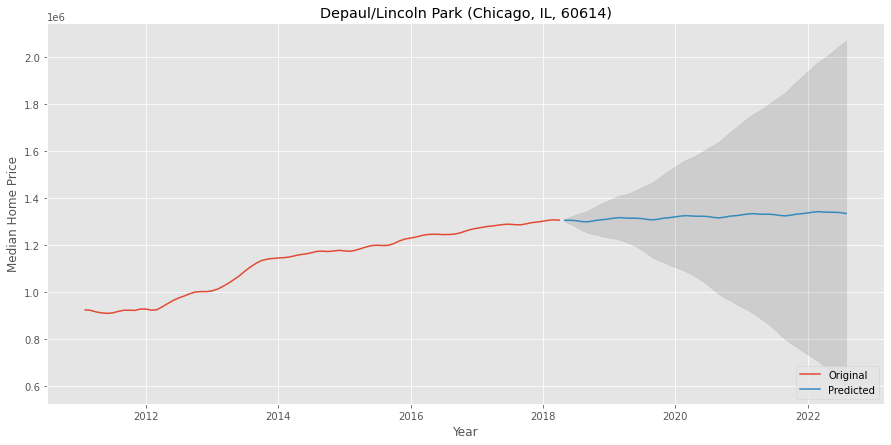

Depaul/Lincoln Park (Chicago, IL, 60614):
95% confidence that the true future value is between $598924 and $2071511
Confidence range: $1472587


In [213]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_mod2 = sm.tsa.statespace.SARIMAX(df_prospects_postcrash[60614],
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

forecast2 = sarima_mod2.get_forecast(steps=52).summary_frame()
forecast2_mean = round(forecast2['mean'][51])
low_int2 =  round(forecast2['mean_ci_lower'][51])
high_int2 = round(forecast2['mean_ci_upper'][51])
ci_delta2 = round(high_int2 - low_int2)


fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_prospects_postcrash[60614])
plt.plot(forecast2['mean'])
ax.fill_between(forecast2.index, forecast2['mean_ci_lower'], 
                    forecast2['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Depaul/Lincoln Park (Chicago, IL, 60614)')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()
    

print(f'Depaul/Lincoln Park (Chicago, IL, 60614):')
print(f'95% confidence that the true future value is between ${low_int2} and ${high_int2}')
print(f'Confidence range: ${ci_delta2}')

### Depaul/Lincoln Park SARIMA Results Summary

## The Bronx/Van Cortland Park (NYC, 10467)

### The Bronx/Van Cortland Park SARIMA Parameters

In [200]:
# Define train and test sets according to the index found above
train3 = df_prospects_postcrash[10467][:cutoff]
valid3 = df_prospects_postcrash[10467][cutoff:]

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []

for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train3,
                                            order = comb,
                                            seasonal_order = combs,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 1952.3672728672839
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1583.4201218543678
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1309.0548619613517
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1039.726698118213
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1311.8286858517333
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1237.7435111901484
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1060.6419205782759
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1387.2904202657098
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1877.539889925758
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1634.6304059180486
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1305.501830364878
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 982.1226532895585
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1587.5621437692635
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1633.8028461525

In [201]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           793.027
Name: 63, dtype: object

### The Bronx/Van Cortland Park SARIMA Predictions

The Mean Absolute Error of our predictions: $13507.14


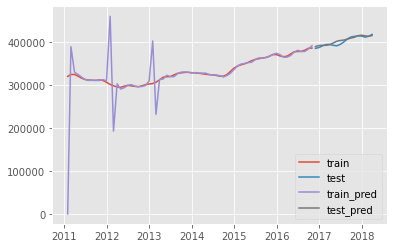

In [202]:
# Plug the optimal parameter values into a new SARIMAX model
sarima3 = sm.tsa.statespace.SARIMAX(train3,
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

y_hat_train3 = sarima3.predict(typ='levels')
y_hat_test3 = sarima3.predict(start=valid3.index[0], end=valid3.index[-1],typ='levels')

# Calculate the mean absolute error from residuals
mae3 = np.mean(np.abs(sarima3.resid))
print('The Mean Absolute Error of our predictions: $%.2f' % mae3)

fig, ax = plt.subplots()
ax.plot(train3, label='train')
ax.plot(valid3, label='test')
ax.plot(y_hat_train3, label='train_pred')
ax.plot(y_hat_test3, label='test_pred')

plt.legend();

### The Bronx/Van Cortland Park SARIMA Forecast

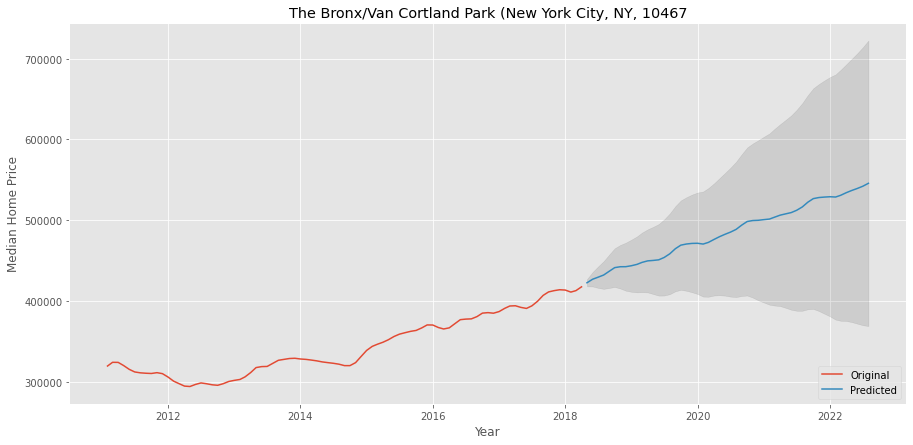

The Bronx/Van Cortland Park (New York City, NY, 10467
95% confidence that the true future value is between $369452 and $722262
Confidence range: $352810


In [214]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_mod3 = sm.tsa.statespace.SARIMAX(df_prospects_postcrash[10467],
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

forecast3 = sarima_mod3.get_forecast(steps=52).summary_frame()
forecast3_mean = round(forecast3['mean'][51])
low_int3 =  round(forecast3['mean_ci_lower'][51])
high_int3 = round(forecast3['mean_ci_upper'][51])
ci_delta3 = round(high_int3 - low_int3)


fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_prospects_postcrash[10467])
plt.plot(forecast3['mean'])
ax.fill_between(forecast3.index, forecast3['mean_ci_lower'], 
                    forecast3['mean_ci_upper'], color='k', alpha=0.1)
plt.title('The Bronx/Van Cortland Park (New York City, NY, 10467')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()
    

print(f'The Bronx/Van Cortland Park (New York City, NY, 10467')
print(f'95% confidence that the true future value is between ${low_int3} and ${high_int3}')
print(f'Confidence range: ${ci_delta3}')

### The Bronx/Van Cortland Park Results Summary

## Uptown (Chicago, IL, 60640)

### Uptown SARIMA Parameters

In [204]:
# Define train and test sets according to the index found above
train4 = df_prospects_postcrash[60640][:cutoff]
valid4 = df_prospects_postcrash[60640][cutoff:]

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []

for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train4,
                                            order = comb,
                                            seasonal_order = combs,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2040.3154718028761
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 1656.4062081502298
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1394.5143486234347
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 1108.3986609124893
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1383.0016263974496
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1288.1015682558157
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 1099.0884346897467
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 1541.381605305733
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1964.4957780810198
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 1610.5366534878785
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1403.156086031353
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 1071.7127455999955
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1661.8267915010729
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1606.59226691

In [205]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           827.021
Name: 63, dtype: object

### Uptown SARIMA Predictions

The Mean Absolute Error of our predictions: $27626.26


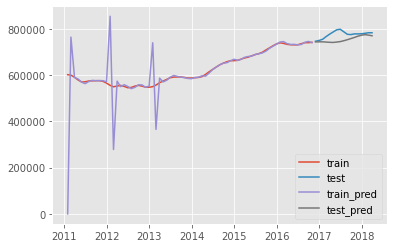

In [206]:
# Plug the optimal parameter values into a new SARIMAX model
sarima4 = sm.tsa.statespace.SARIMAX(train4,
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

y_hat_train4 = sarima4.predict(typ='levels')
y_hat_test4 = sarima4.predict(start=valid4.index[0], end=valid4.index[-1],typ='levels')

# Calculate the mean absolute error from residuals
mae4 = np.mean(np.abs(sarima4.resid))
print('The Mean Absolute Error of our predictions: $%.2f' % mae4)

fig, ax = plt.subplots()
ax.plot(train4, label='train')
ax.plot(valid4, label='test')
ax.plot(y_hat_train4, label='train_pred')
ax.plot(y_hat_test4, label='test_pred')

plt.legend();

### Uptown SARIMA Forecast

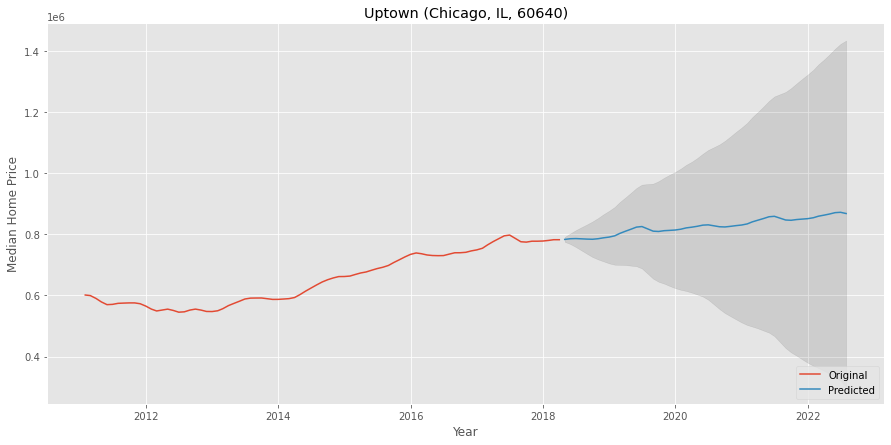

Uptown (Chicago, IL, 60640):
95% confidence that the true future value is between $301783 and $1435313
Confidence range: $1133530


In [215]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_mod4 = sm.tsa.statespace.SARIMAX(df_prospects_postcrash[60640],
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

forecast4 = sarima_mod4.get_forecast(steps=52).summary_frame()
forecast4_mean = round(forecast4['mean'][51])
low_int4 =  round(forecast4['mean_ci_lower'][51])
high_int4 = round(forecast4['mean_ci_upper'][51])
ci_delta4 = round(high_int4 - low_int4)


fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_prospects_postcrash[60640])
plt.plot(forecast4['mean'])
ax.fill_between(forecast4.index, forecast4['mean_ci_lower'], 
                    forecast4['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Uptown (Chicago, IL, 60640)')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()
    

print(f'Uptown (Chicago, IL, 60640):')
print(f'95% confidence that the true future value is between ${low_int4} and ${high_int4}')
print(f'Confidence range: ${ci_delta4}')

### Uptown Results Summary

## Katy, TX (Houston Suburb, 77449)

### Katy SARIMA Parameters

In [208]:
# Define train and test sets according to the index found above
train5 = df_prospects_postcrash[77449][:cutoff]
valid5 = df_prospects_postcrash[77449][cutoff:]

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []

for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train5,
                                            order = comb,
                                            seasonal_order = combs,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 1827.873172534511
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 169407.9191541925
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 1232.4236564752825
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 985.2500203168044
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 1186.320479934198
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 1189.4581574650285
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 935.5324624295959
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 917.8658867040846
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 1755.2721107835443
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 153642.6886173263
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 1184.021585548715
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 1378.80769398341
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 1584.023564548756
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 1434.4227372141138
ARI

In [209]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           615.691
Name: 63, dtype: object

### Katy SARIMA Predictions

The Mean Absolute Error of our predictions: $4466.01


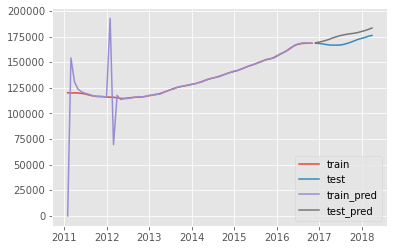

In [210]:
# Plug the optimal parameter values into a new SARIMAX model
sarima5 = sm.tsa.statespace.SARIMAX(train5,
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

y_hat_train5 = sarima5.predict(typ='levels')
y_hat_test5 = sarima5.predict(start=valid5.index[0], end=valid5.index[-1],typ='levels')

# Calculate the mean absolute error from residuals
mae5 = np.mean(np.abs(sarima5.resid))
print('The Mean Absolute Error of our predictions: $%.2f' % mae5)

fig, ax = plt.subplots()
ax.plot(train5, label='train')
ax.plot(valid5, label='test')
ax.plot(y_hat_train5, label='train_pred')
ax.plot(y_hat_test5, label='test_pred')

plt.legend();

### Katy SARIMA Forecast

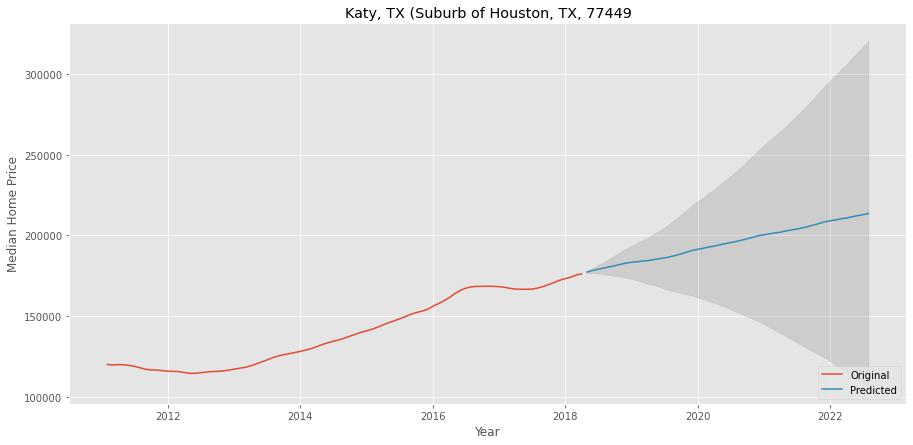

Katy, TX (Suburb of Houston, TX, 77449:
95% confidence that the true future value is between $106555 and $320536
Confidence range: $213981


In [216]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_mod5 = sm.tsa.statespace.SARIMAX(df_prospects_postcrash[77449],
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()

forecast5 = sarima_mod5.get_forecast(steps=52).summary_frame()
forecast5_mean = round(forecast5['mean'][51])
low_int5 =  round(forecast5['mean_ci_lower'][51])
high_int5 = round(forecast5['mean_ci_upper'][51])
ci_delta5 = round(high_int5 - low_int5)


fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_prospects_postcrash[77449])
plt.plot(forecast5['mean'])
ax.fill_between(forecast5.index, forecast5['mean_ci_lower'], 
                    forecast5['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Katy, TX (Suburb of Houston, TX, 77449')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()


print(f'Katy, TX (Suburb of Houston, TX, 77449:')
print(f'95% confidence that the true future value is between ${low_int5} and ${high_int5}')
print(f'Confidence range: ${ci_delta5}')

### Katy Results Summary

# Evaluation

In [235]:
d = {'zipcode': [60657, 60614, 10467, 60640, 77449],
     'city': ['Lakeview (Chicago)',
              'Depaul/Lincoln Park (Chicago)',
              'The Bronx/Van Cortland Park (NYC)',
              'Uptown (Chicago)',
              'Katy, TX (Houston)'],
     '2018 median value': [1030600, 1307000, 417900, 782800, 176200],
     'mae': [mae1, mae2, mae3, mae4, mae5],
     'low_conf': [low_int1, low_int2, low_int3, low_int4, low_int5],
     'high_conf': [high_int1, high_int2, high_int3, high_int4, high_int5],
     'forecast range': [ci_delta1, ci_delta2, ci_delta3, ci_delta4, ci_delta5]}

df_results = pd.DataFrame(data=d)
df_results['low_end'] = df_results['2018 median value'] + df_results['low_conf']
df_results['high_end'] = df_results['2018 median value'] + df_results['high_conf']

In [236]:
df_results

,zipcode,city,2018 median value,mae,low_conf,high_conf,forecast range,low_end,high_end
0,60657,Lakeview (Chicago),1030600,44097.363722,759441,1624075,864634,1790041,2654675
1,60614,Depaul/Lincoln Park (Chicago),1307000,58447.741423,598924,2071511,1472587,1905924,3378511
2,10467,The Bronx/Van Cortland Park (NYC),417900,13507.136939,369452,722262,352810,787352,1140162
3,60640,Uptown (Chicago),782800,27626.262986,301783,1435313,1133530,1084583,2218113
4,77449,"Katy, TX (Houston)",176200,4466.014997,106555,320536,213981,282755,496736


1. The zipcode model with the smallest MAE of only 4,466 was Katy, TX (77449)
2. The zipcode forecast with the smallest 95% confidence interval range (thus perhaps the less risky) is also Katy, TX, with a range of only 213,981
3. On the contrary, the zipcode model with the highest MAE was Depaul/Lincoln Park of Chicago (60614) at 58,447
4. Depaul/Lincoln Park also has the widest confidence interval range, incidating a more risky option, with a range of 1,472,587

# Recommendations

For those clients who may be more risk-averse, possibly with less cash on hand, Katy, TX (77449) and The Bronx/Van Cortland Park (10467) may be the best zipcodes in which to invest because:

* In Katy, the median home value in 2018 was 176,200 and our model predictions only deviated by as much as 4500. Further, forecasted Katy home values two years out have a less varied range than other zipcodes. Thus, in two years, we can expect home values to increase on the low end to 282,755 and the high end 496,736.

* In the Bronx, the median home value in 2018 was 417,900 and our model predictions deviated by as much as 13,507. Further, forecasted home values in the Bronx two years out have a less varied range than other zipcodes. Thus, in two years, we can expect home values to increase on the low end to 787,352 and the high end 1,140,162.


For those clients who may be more willing to take a risk, and perhaps with more cash on hand, the Lakeview and Depaul/Lincoln Park neighborhoods of Chicago may be the best zipcobes in which to invest because:

* In Lakeview, the median home value in 2018 was 1,030,600. In making our predictions, our model deviated by as much as 44,097. Forecasted Lakeview home values two years out have a more varied range than other zipcodes. Thus, in two years, we can expect home values to increase on the low end to 1,790,041 and the high end 2,654,675.

* In Depaul/Lincoln Park, the median home value in 2018 was 1,307,000. In making our predictions, our model deviated by as much as 58,447. Forecasted Depaul/Lincoln Park home values two years out have a more varied range than other zipcodes. Thus, in two years, we can expect home values to increase on the low end to 1,905,924 and the high end 3,368,511.


For clients looking for a good, middle-of-the-road investment zipcode with an above average median home value and moderate error in predictions, the Uptown neighborhood of Chicago would be a sound option. In Uptown, the median home value in 2018 was 782,800. In making our predictions, our model deviated by as much as 27,626. Forecasted Uptown home values two years out do have a more varied range than other zipcodes, which we may note of in terms of potential risk. Thus, in two years, we can expect home values to increase on the low end to 1,084,583 and the high end 2,218,113.

# Future Work